# Project 2: SOFR Futures and Policy Expectations

This notebook uses SOFR futures to infer market expectations of Fed policy during the 2022–2024 cycle, evaluate forecast accuracy, and measure transmission to the Treasury curve.

**Data files (provided):**
- `project_sofr_futures_20251231.xlsx`
- `project_fomc_dates.xlsx`
- `project_gsw_yields_20251231.xlsx`
- `ref_rates.xlsx`


## Setup & Data Load

In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

FIGSIZE = (12, 5)

SOFR_XLSX = os.path.join(os.getcwd(), "data/project_sofr_futures_20251231.xlsx")
FOMC_XLSX = os.path.join(os.getcwd(), "data/project_fomc_dates.xlsx")
GSW_XLSX  = os.path.join(os.getcwd(), "data/project_gsw_yields_20251231.xlsx")
REF_XLSX  = os.path.join(os.getcwd(), "data/ref_rates.xlsx")

# --- SOFR futures ---
sofr_prices = pd.read_excel(SOFR_XLSX, sheet_name="prices")
sofr_implied = pd.read_excel(SOFR_XLSX, sheet_name="implied_rates")  # already computed in file
contract_info = pd.read_excel(SOFR_XLSX, sheet_name="contract_info")

sofr_prices["date"] = pd.to_datetime(sofr_prices["date"])
sofr_implied["date"] = pd.to_datetime(sofr_implied["date"])
contract_info["expiry_date"] = pd.to_datetime(contract_info["expiry_date"])

sofr_prices = sofr_prices.set_index("date").sort_index()
sofr_implied = sofr_implied.set_index("date").sort_index()

# If you prefer to compute implied from price, uncomment:
# sofr_implied = 100 - sofr_prices

# --- FOMC dates ---
fomc = pd.read_excel(FOMC_XLSX)
fomc["date"] = pd.to_datetime(fomc["date"])
fomc_2224 = fomc[(fomc["year"]>=2022) & (fomc["year"]<=2024)].copy().reset_index(drop=True)

# --- Treasury yields (GSW key maturities) ---
gsw = pd.read_excel(GSW_XLSX, sheet_name="gsw_yields_key")
gsw["date"] = pd.to_datetime(gsw["date"])
gsw = gsw.set_index("date").sort_index()
gsw_2224 = gsw.loc["2022":"2024"].copy()

# --- Reference rates ---
ref_rates = pd.read_excel(REF_XLSX, sheet_name="data")
ref_rates["date"] = pd.to_datetime(ref_rates["date"])
ref_rates = ref_rates.set_index("date").sort_index()

display(contract_info.head())
print("SOFR implied shape:", sofr_implied.shape, "date range:", sofr_implied.index.min().date(), "→", sofr_implied.index.max().date())
print("FOMC 2022–2024 meetings:", len(fomc_2224))
print("GSW 2022–2024 shape:", gsw_2224.shape)
print("Ref rates columns:", list(ref_rates.columns))


,ticker,expiry_month,expiry_year,expiry_date
0,SR3H2,3,2022,2022-03-16
1,SR3M2,6,2022,2022-06-15
2,SR3U2,9,2022,2022-09-21
3,SR3Z2,12,2022,2022-12-21
4,SR3H3,3,2023,2023-03-15


SOFR implied shape: (1244, 20) date range: 2022-01-02 → 2025-12-30
FOMC 2022–2024 meetings: 24
GSW 2022–2024 shape: (782, 3)
Ref rates columns: ['DTB3', 'DFF', 'SOFR']


## Helper functions

In [3]:

def contracts_sorted_by_expiry():
    ci = contract_info.sort_values("expiry_date")
    return ci["ticker"].tolist(), ci.set_index("ticker")["expiry_date"].to_dict()

TICKERS_SORTED, EXPIRY = contracts_sorted_by_expiry()

def nearest_trading_day(idx, target_ts):
    pos = idx.get_indexer([pd.Timestamp(target_ts)], method="nearest")[0]
    return idx[pos]

def prev_trading_day(idx, target_ts):
    target_ts = pd.Timestamp(target_ts)
    prev = idx[idx < target_ts]
    return prev.max() if len(prev) else None

def next_trading_day(idx, target_ts):
    target_ts = pd.Timestamp(target_ts)
    nxt = idx[idx > target_ts]
    return nxt.min() if len(nxt) else None

def front_and_second_contract(date_ts):
    ci = contract_info.sort_values("expiry_date")
    ci = ci[ci["expiry_date"] > pd.Timestamp(date_ts)]
    if len(ci) < 2:
        return None, None
    return ci.iloc[0]["ticker"], ci.iloc[1]["ticker"]

def curve_on(date_ts):
    row = sofr_implied.loc[date_ts].dropna()
    ci = contract_info.set_index("ticker").loc[row.index].copy()
    ci["rate"] = row.values
    ci = ci.sort_values("expiry_date")
    return ci["expiry_date"].values, ci["rate"].values, ci.index.tolist()

def terminal_rate_series():
    return sofr_implied.max(axis=1)

def classify_surprise(x, threshold_bp=5):
    thr = threshold_bp/100  # 5 bp = 0.05%
    if x > thr: return "Hawkish"
    if x < -thr: return "Dovish"
    return "As expected"


## Question 1: Building the Expectations Curve

We build the implied rate term structure from SOFR futures and track how the **terminal rate** (the peak implied rate across contracts) evolved.

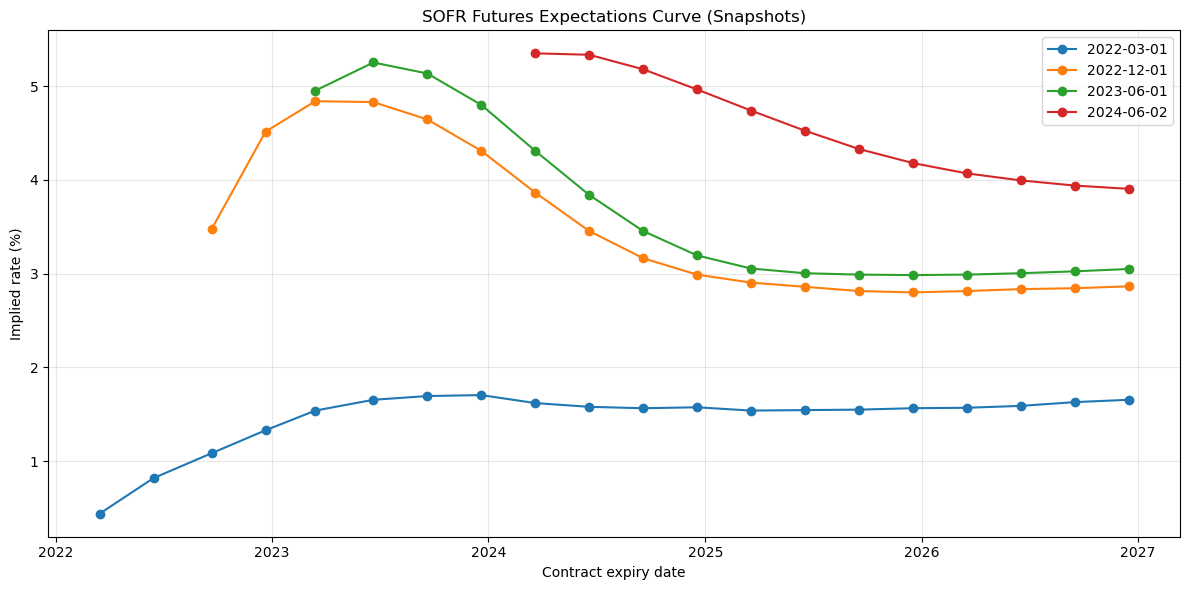

In [4]:

snapshot_dates = [pd.Timestamp("2022-03-01"), pd.Timestamp("2022-12-01"), pd.Timestamp("2023-06-01"), pd.Timestamp("2024-06-01")]

plt.figure(figsize=(12,6))
for d in snapshot_dates:
    d0 = nearest_trading_day(sofr_implied.index, d)
    x_dates, y_rates, _ = curve_on(d0)
    plt.plot(x_dates, y_rates, marker="o", label=str(d0.date()))
plt.title("SOFR Futures Expectations Curve (Snapshots)")
plt.xlabel("Contract expiry date")
plt.ylabel("Implied rate (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:

term = terminal_rate_series()

first_above_5 = term[term > 5.0]
first_above_5_date = first_above_5.index.min() if len(first_above_5) else None

roll_max = term.cummax()
cuts_proxy = term[(roll_max - term) >= 0.25]  # down ≥25 bp from cum max
cuts_proxy_date = cuts_proxy.index.min() if len(cuts_proxy) else None

peak_date = term.idxmax()
peak_val  = term.max()

print("Terminal rate peak:", f"{peak_val:.3f}%", "on", peak_date.date())
print("First date terminal > 5%:", first_above_5_date.date() if first_above_5_date is not None else None)
print("Cuts begin proxy date (terminal down ≥25bp from cumulative max):", cuts_proxy_date.date() if cuts_proxy_date is not None else None)


Terminal rate peak: 5.695% on 2023-03-08
First date terminal > 5%: 2022-11-01
Cuts begin proxy date (terminal down ≥25bp from cumulative max): 2022-03-01


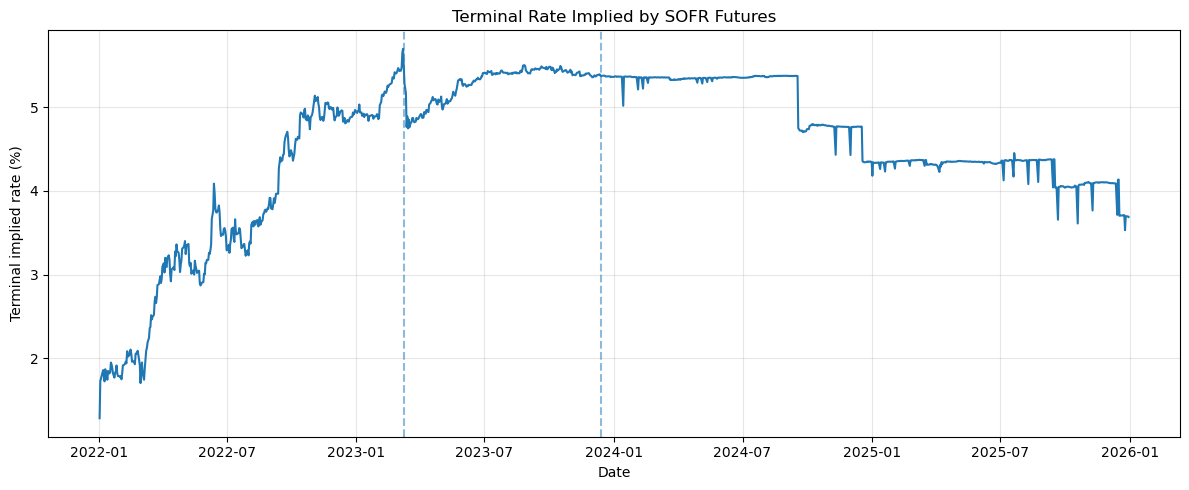

In [6]:

term = terminal_rate_series()
svb = pd.Timestamp("2023-03-10")
powell_pivot = pd.Timestamp("2023-12-13")

plt.figure(figsize=FIGSIZE)
plt.plot(term.index, term.values, linewidth=1.5)
plt.axvline(svb, linestyle="--", alpha=0.5)
plt.axvline(powell_pivot, linestyle="--", alpha=0.5)
plt.title("Terminal Rate Implied by SOFR Futures")
plt.xlabel("Date")
plt.ylabel("Terminal implied rate (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretation (Q1):**

- Terminal rate rises through 2022 as markets price aggressive tightening.
- A terminal rate above 5% appears once markets internalize a higher hiking path.
- Expectations for cuts show up when the terminal rate falls from its peak—often around stress/pivot events.


## Question 2: FOMC Meeting Surprises

For each FOMC meeting, we compute the change in the **front** SOFR implied rate from the trading day **before** to the trading day **after** the meeting.

In [7]:

rows = []
idx = sofr_implied.index

for _, r in fomc_2224.iterrows():
    m = pd.Timestamp(r["date"])
    d_prev = prev_trading_day(idx, m)
    d_next = next_trading_day(idx, m)
    if (d_prev is None) or (d_next is None):
        continue
    
    c_prev, _ = front_and_second_contract(d_prev)
    c_next, _ = front_and_second_contract(d_next)
    if (c_prev is None) or (c_next is None):
        continue
    
    rate_prev = sofr_implied.loc[d_prev, c_prev]
    rate_next = sofr_implied.loc[d_next, c_next]
    if pd.isna(rate_prev) or pd.isna(rate_next):
        continue
    
    surprise = rate_next - rate_prev
    rows.append({
        "meeting_date": m.date(),
        "prev_day": d_prev.date(),
        "next_day": d_next.date(),
        "front_prev": c_prev,
        "front_next": c_next,
        "rate_prev": rate_prev,
        "rate_next": rate_next,
        "surprise": surprise,
        "class": classify_surprise(surprise, 5)
    })

fomc_surprises = pd.DataFrame(rows).sort_values("meeting_date").reset_index(drop=True)
display(fomc_surprises.head(10))
print("Meetings computed:", len(fomc_surprises))


,meeting_date,prev_day,next_day,front_prev,front_next,rate_prev,rate_next,surprise,class
0,2022-01-26,2022-01-25,2022-01-27,SR3H2,SR3H2,0.3650,0.4400,0.0750,Hawkish
1,2022-03-16,2022-03-15,2022-03-17,SR3H2,SR3M2,0.5125,1.1250,0.6125,Hawkish
2,2022-05-04,2022-05-03,2022-05-05,SR3M2,SR3M2,1.6600,1.6250,-0.0350,As expected
3,2022-06-15,2022-06-14,2022-06-16,SR3M2,SR3U2,1.9000,3.0850,1.1850,Hawkish
4,2022-07-27,2022-07-26,2022-07-28,SR3U2,SR3U2,3.0950,3.0050,-0.0900,Dovish
5,2022-09-21,2022-09-20,2022-09-22,SR3U2,SR3Z2,3.4625,4.3650,0.9025,Hawkish
6,2022-11-02,2022-11-01,2022-11-03,SR3Z2,SR3Z2,4.6150,4.6350,0.0200,As expected
7,2022-12-14,2022-12-13,2022-12-15,SR3Z2,SR3Z2,4.5025,4.4975,-0.0050,As expected
8,2023-02-01,2023-01-31,2023-02-02,SR3H3,SR3H3,4.8400,4.8250,-0.0150,As expected
9,2023-03-22,2023-03-21,2023-03-23,SR3M3,SR3M3,4.8000,4.6100,-0.1900,Dovish


Meetings computed: 24


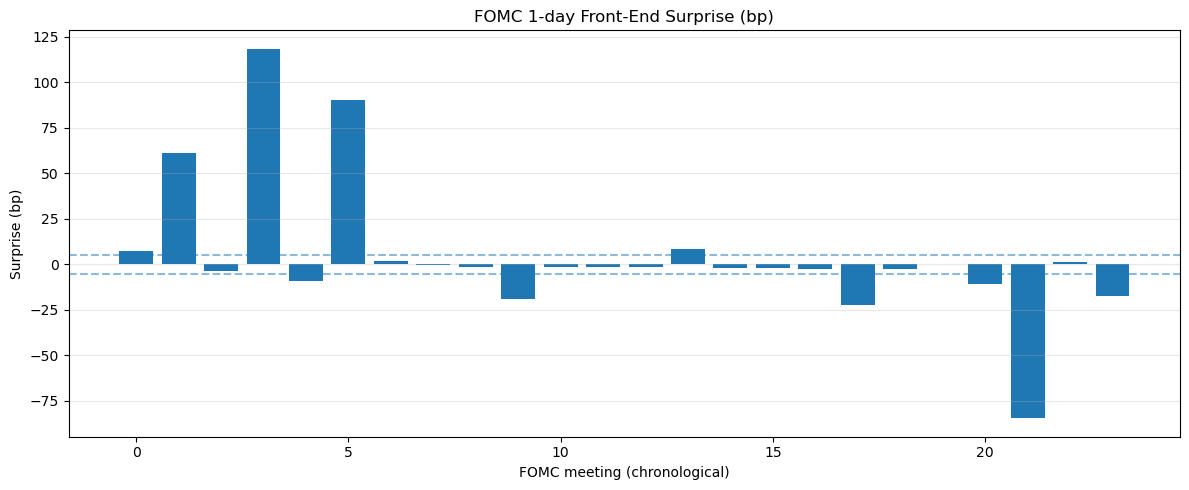

class
As expected    13
Dovish          6
Hawkish         5
Name: count, dtype: int64

In [8]:

sur_bp = 100 * fomc_surprises["surprise"]  # % to bp

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(sur_bp)), sur_bp.values)
plt.axhline(5, linestyle="--", alpha=0.5)
plt.axhline(-5, linestyle="--", alpha=0.5)
plt.title("FOMC 1-day Front-End Surprise (bp)")
plt.xlabel("FOMC meeting (chronological)")
plt.ylabel("Surprise (bp)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

display(fomc_surprises["class"].value_counts())


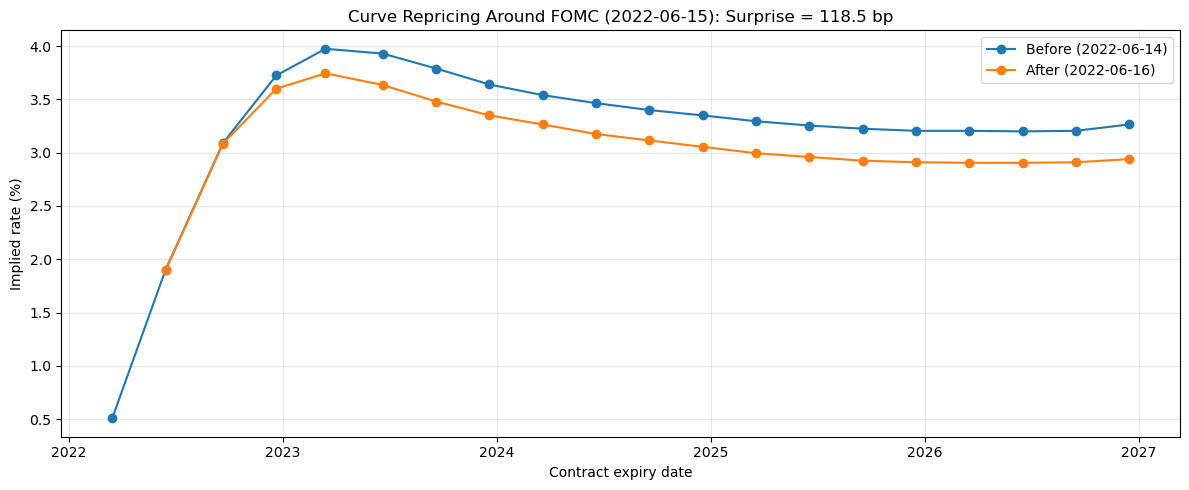

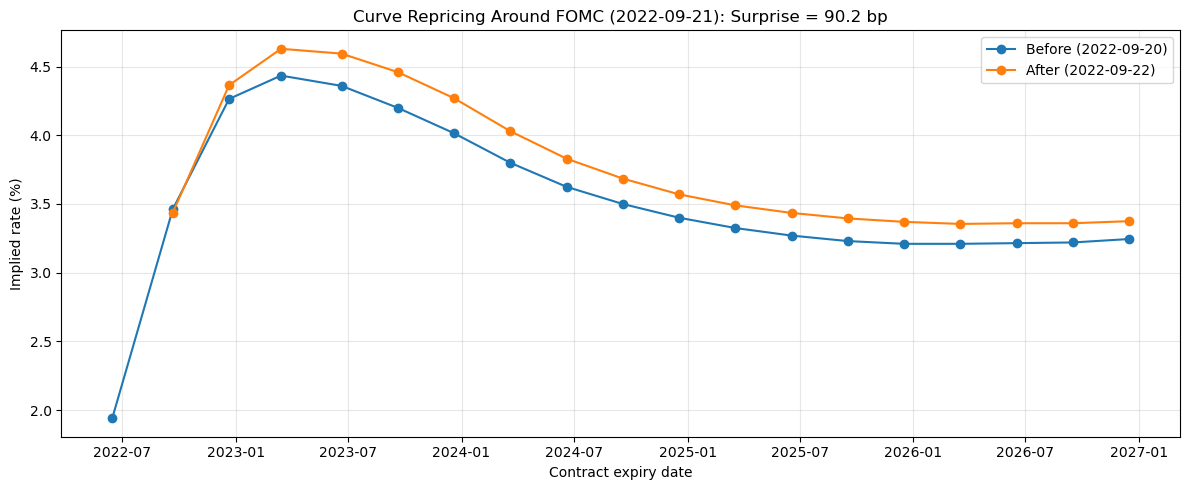

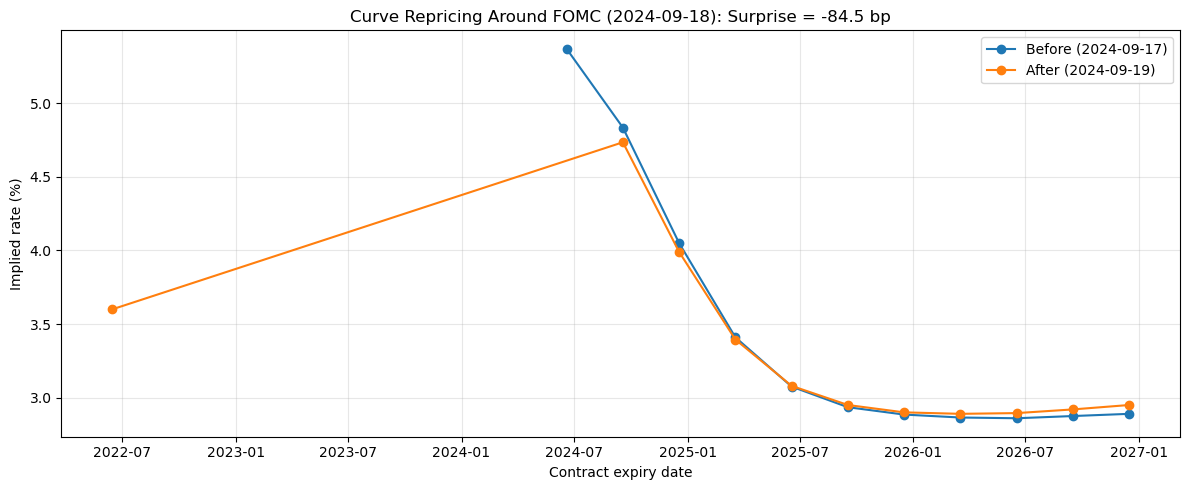

In [9]:

top = fomc_surprises.reindex(fomc_surprises["surprise"].abs().sort_values(ascending=False).index).head(3)

for _, row in top.iterrows():
    d_prev = pd.Timestamp(row["prev_day"])
    d_next = pd.Timestamp(row["next_day"])
    
    x1, y1, _ = curve_on(d_prev)
    x2, y2, _ = curve_on(d_next)
    
    plt.figure(figsize=(12,5))
    plt.plot(x1, y1, marker="o", label=f"Before ({d_prev.date()})")
    plt.plot(x2, y2, marker="o", label=f"After ({d_next.date()})")
    plt.title(f"Curve Repricing Around FOMC ({row['meeting_date']}): Surprise = {row['surprise']*100:.1f} bp")
    plt.xlabel("Contract expiry date")
    plt.ylabel("Implied rate (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Question 3: Forecast Accuracy (3-month horizon, **monthly** evaluation)

We evaluate forecast accuracy **for each month** in 2022–2024.

**Step 1 (monthly evaluation date):** take the first available trading day in each month, denoted \(t\).

**Step 2 (3‑month‑ahead contract mapping):** set a target date \(t^{+3m} = t + 3\) months.  
Choose the **first SOFR futures contract whose expiry (IMM date) is on/after \(t^{+3m}\)**. Call this contract \(c(t)\).  
This makes the comparison “month-by-month” while still respecting the futures contracts’ IMM structure.

**Step 3 (implied vs realized):**
- **Implied rate:** \(r^{\text{impl}}_t = \text{SOFR implied}(t, c(t))\)
- **Realized rate:** average daily SOFR over the 3 months **leading up to** the contract expiry (IMM-to-IMM approximation):
  
\[ r^{\text{real}}_{c} = \frac{1}{N}\sum_{s \in [\text{expiry}-3m,\, \text{expiry}]} \text{SOFR}_s \]
- **Error:** \(\text{error}_t = r^{\text{real}}_{c(t)} - r^{\text{impl}}_t\)

This produces a monthly time series of forecast errors.


In [10]:
# Realized average SOFR for each contract (IMM-to-IMM approximation: 3 months leading up to expiry)
sofr_ref = ref_rates["SOFR"].dropna().copy()

realized = {}
for tkr, exp in EXPIRY.items():
    start = exp - pd.DateOffset(months=3)
    end = exp
    window = sofr_ref.loc[start:end]
    realized[tkr] = window.mean() if len(window) else np.nan

realized = pd.Series(realized, name="realized_sofr_avg").sort_index()
display(realized.dropna().head(10))
print("Realized rates available for", realized.dropna().shape[0], "contracts (out of", len(realized), ")")


SR3H2    0.049032
SR3H3    4.421803
SR3H4    5.318065
SR3H5    4.335902
SR3H6    3.714444
SR3M2    0.496462
SR3M3    4.929062
SR3M4    5.317656
SR3M5    4.321077
SR3U2    1.974769
Name: realized_sofr_avg, dtype: float64

Realized rates available for 17 contracts (out of 20 )


In [11]:
# Monthly evaluation dates: first trading day each month in 2022–2024
monthly_starts = pd.date_range("2022-01-01", "2024-12-01", freq="MS")

def contract_3m_ahead(eval_date):
    """Pick first contract with expiry >= eval_date + 3 months."""
    target = pd.Timestamp(eval_date) + pd.DateOffset(months=3)
    ci = contract_info.sort_values("expiry_date")
    ci = ci[ci["expiry_date"] >= target]
    if len(ci) == 0:
        return None
    return ci.iloc[0]["ticker"]

rows = []
for d in monthly_starts:
    # first trading day in the month (nearest next trading day)
    t = next_trading_day(sofr_implied.index, d - pd.Timedelta(days=1))
    if t is None:
        continue

    c = contract_3m_ahead(t)
    if c is None or c not in sofr_implied.columns:
        continue

    implied_at_t = sofr_implied.loc[t, c]
    realized_c = realized.get(c, np.nan)
    if pd.isna(implied_at_t) or pd.isna(realized_c):
        continue

    # Directional accuracy vs spot SOFR at t (rough diagnostic)
    spot = sofr_ref.reindex([t], method="nearest").iloc[0]
    pred_change = implied_at_t - spot
    real_change = realized_c - spot
    direction_correct = np.sign(pred_change) == np.sign(real_change)

    rows.append({
        "t": t,
        "contract_3m_ahead": c,
        "expiry": EXPIRY[c],
        "implied_rate": implied_at_t,
        "realized_avg": realized_c,
        "error": realized_c - implied_at_t,
        "spot_sofr": spot,
        "direction_correct": bool(direction_correct)
    })

fcst = pd.DataFrame(rows).sort_values("t").reset_index(drop=True)
display(fcst.head(10))
print("Monthly observations:", len(fcst))


,t,contract_3m_ahead,expiry,implied_rate,realized_avg,error,spot_sofr,direction_correct
0,2022-01-02,SR3M2,2022-06-15,0.465,0.496462,0.031462,0.05,True
1,2022-02-01,SR3M2,2022-06-15,0.790,0.496462,-0.293538,0.05,True
2,2022-03-01,SR3M2,2022-06-15,0.820,0.496462,-0.323538,0.05,True
3,2022-04-01,SR3U2,2022-09-21,2.105,1.974769,-0.130231,0.30,True
4,2022-05-01,SR3U2,2022-09-21,2.490,1.974769,-0.515231,0.30,True
5,2022-06-01,SR3U2,2022-09-21,2.375,1.974769,-0.400231,0.80,True
6,2022-07-01,SR3Z2,2022-12-21,3.290,3.458254,0.168254,1.52,True
7,2022-08-01,SR3Z2,2022-12-21,3.230,3.458254,0.228254,2.28,True
8,2022-09-01,SR3Z2,2022-12-21,3.790,3.458254,-0.331746,2.29,True
9,2022-10-02,SR3H3,2023-03-15,4.435,4.421803,-0.013197,3.00,True


Monthly observations: 36


Mean error (bias): 0.0629 %
RMSE:             0.3581 %
Directional accuracy: 88.9%


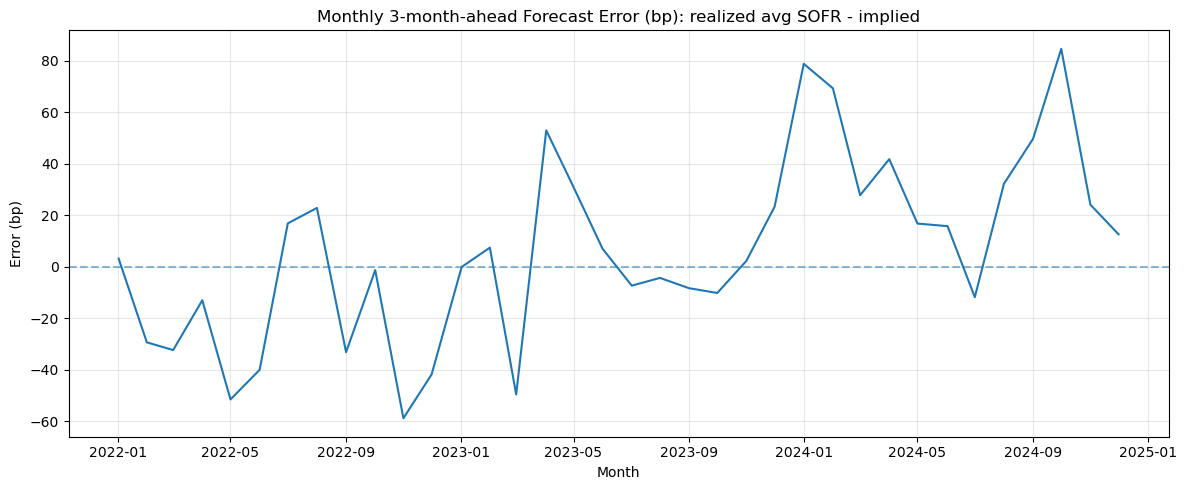

contract_3m_ahead
SR3M2    3
SR3U2    3
SR3Z2    3
SR3H3    3
SR3M3    3
SR3U3    3
SR3Z3    3
SR3H4    3
SR3M4    3
SR3U4    3
SR3Z4    3
SR3H5    3
Name: count, dtype: int64

In [12]:
# Summary statistics (monthly)
bias = fcst["error"].mean()
rmse = np.sqrt(np.mean(fcst["error"]**2))
directional = fcst["direction_correct"].mean()

print(f"Mean error (bias): {bias:.4f} %")
print(f"RMSE:             {rmse:.4f} %")
print(f"Directional accuracy: {directional*100:.1f}%")

plt.figure(figsize=FIGSIZE)
plt.plot(fcst["t"], fcst["error"]*100)  # in bp
plt.axhline(0, linestyle="--", alpha=0.5)
plt.title("Monthly 3-month-ahead Forecast Error (bp): realized avg SOFR - implied")
plt.xlabel("Month")
plt.ylabel("Error (bp)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: show which contracts are being used over time
display(fcst["contract_3m_ahead"].value_counts())


In [13]:
# Regime split (same dates as the rest of the notebook)
hike = fcst[(fcst["t"]>=pd.Timestamp("2022-03-01")) & (fcst["t"]<=pd.Timestamp("2023-07-31"))]
plateau = fcst[(fcst["t"]>=pd.Timestamp("2023-08-01")) & (fcst["t"]<=pd.Timestamp("2024-12-31"))]

def stats_block(df):
    return pd.Series({
        "N": len(df),
        "Bias (%)": df["error"].mean(),
        "RMSE (%)": np.sqrt(np.mean(df["error"]**2)),
        "Directional Acc.": df["direction_correct"].mean()
    })

reg_table = pd.DataFrame({
    "Hiking (Mar 2022–Jul 2023)": stats_block(hike),
    "Plateau/Cutting (Aug 2023–Dec 2024)": stats_block(plateau),
}).T

display(reg_table)


,N,Bias (%),RMSE (%),Directional Acc.
Hiking (Mar 2022–Jul 2023),17.0,-0.112493,0.333983,0.941176
Plateau/Cutting (Aug 2023–Dec 2024),17.0,0.261205,0.393485,0.823529


## Question 4: Transmission to the Treasury Curve

Relate the 1-day change in the front SOFR implied rate to 1-day changes in Treasury yields (2Y, 5Y, 10Y) around FOMC meetings.

In [14]:

tx_rows = []
for _, row in fomc_surprises.iterrows():
    d_prev = pd.Timestamp(row["prev_day"])
    d_next = pd.Timestamp(row["next_day"])
    
    y_prev = nearest_trading_day(gsw_2224.index, d_prev)
    y_next = nearest_trading_day(gsw_2224.index, d_next)
    
    dy = gsw_2224.loc[y_next, ["2Y","5Y","10Y"]] - gsw_2224.loc[y_prev, ["2Y","5Y","10Y"]]
    tx_rows.append({
        "meeting_date": pd.Timestamp(row["meeting_date"]),
        "front_surprise": row["surprise"],
        "d2y": dy["2Y"],
        "d5y": dy["5Y"],
        "d10y": dy["10Y"]
    })

tx = pd.DataFrame(tx_rows).dropna()
display(tx.head())
print("Transmission sample size:", len(tx))


,meeting_date,front_surprise,d2y,d5y,d10y
0,2022-01-26,0.0750,0.1082,0.0961,0.0593
1,2022-03-16,0.6125,0.0659,0.0794,0.0645
2,2022-05-04,-0.0350,-0.0276,0.0042,0.0307
3,2022-06-15,1.1850,-0.2071,-0.2443,-0.2338
4,2022-07-27,-0.0900,-0.1489,-0.1526,-0.1349


Transmission sample size: 24


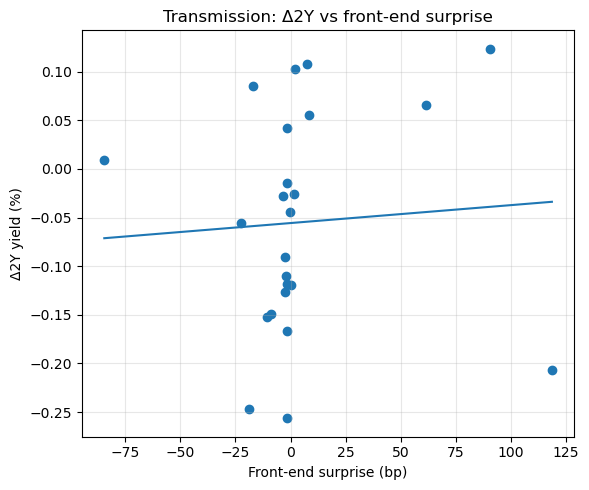

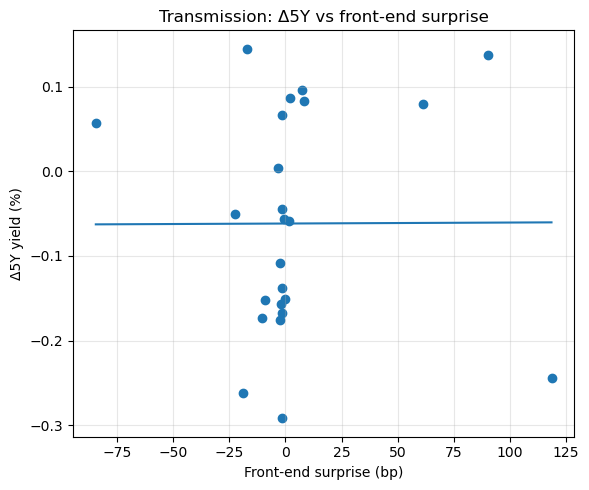

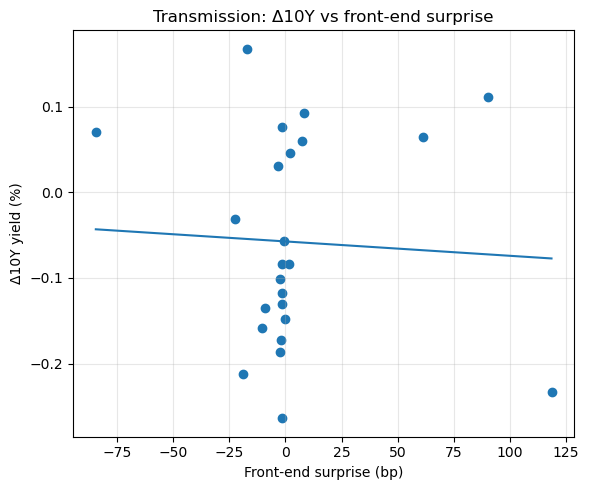

,maturity,beta,alpha,R2,N
0,2Y,0.018444,-0.055674,0.003927,24
1,5Y,0.001163,-0.061627,0.000011,24
2,10Y,-0.016772,-0.057480,0.002763,24


In [15]:

results = []
for col, label in [("d2y","2Y"), ("d5y","5Y"), ("d10y","10Y")]:
    x = tx["front_surprise"].values
    y = tx[col].values
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    results.append({"maturity": label, "beta": model.params[1], "alpha": model.params[0], "R2": model.rsquared, "N": int(model.nobs)})
    
    plt.figure(figsize=(6,5))
    plt.scatter(x*100, y)
    xx = np.linspace(x.min(), x.max(), 100)
    yy = model.params[0] + model.params[1]*xx
    plt.plot(xx*100, yy)
    plt.title(f"Transmission: Δ{label} vs front-end surprise")
    plt.xlabel("Front-end surprise (bp)")
    plt.ylabel(f"Δ{label} yield (%)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

tx_table = pd.DataFrame(results)
display(tx_table)


In [16]:

tx["pattern"] = np.where((tx["front_surprise"]>0) & (tx["d10y"]<0), "Front up, 10Y down",
                 np.where((tx["front_surprise"]<0) & (tx["d10y"]>0), "Front down, 10Y up", "Normal"))

unusual = tx[tx["pattern"]!="Normal"].copy()
display(unusual.sort_values("meeting_date"))


,meeting_date,front_surprise,d2y,d5y,d10y,pattern
2,2022-05-04,-0.0350,-0.0276,0.0042,0.0307,"Front down, 10Y up"
3,2022-06-15,1.1850,-0.2071,-0.2443,-0.2338,"Front up, 10Y down"
12,2023-07-26,-0.0150,0.0421,0.0663,0.0757,"Front down, 10Y up"
21,2024-09-18,-0.8450,0.0095,0.0567,0.0706,"Front down, 10Y up"
22,2024-11-07,0.0150,-0.0260,-0.0585,-0.0835,"Front up, 10Y down"
23,2024-12-18,-0.1725,0.0856,0.1449,0.1674,"Front down, 10Y up"


## Question 5: Event Deep-Dive (SVB collapse)

Event date: **March 10, 2023**.

We plot the full curve 1 week before, the day after, and 1 month after; then quantify terminal and near-term repricing and a persistence ratio.

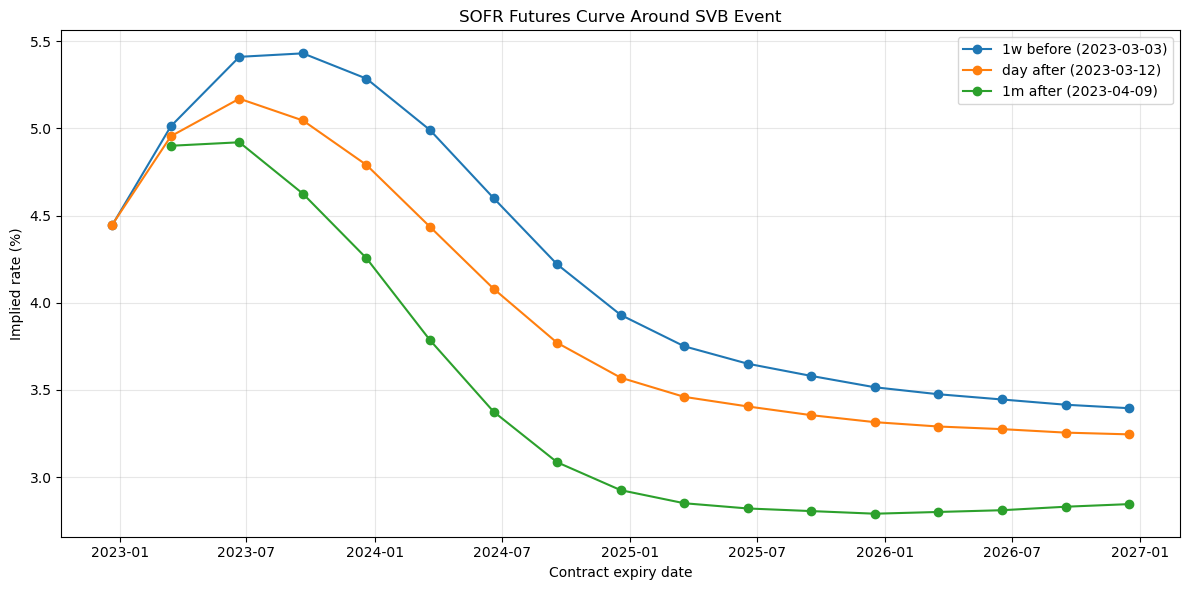

Terminal shift (day after - 1w before): -26.00000000000051 bp
Terminal shift (1m after - 1w before): -51.00000000000051 bp
Near-term (first 2) shift, immediate: -2.7499999999996305 bp
Near-term (first 2) shift, 1m: 18.12500000000057 bp
Persistence ratio (1m / immediate): 1.9615384615384426


In [17]:

event = pd.Timestamp("2023-03-10")

d_before = nearest_trading_day(sofr_implied.index, event - pd.Timedelta(days=7))
d_after  = next_trading_day(sofr_implied.index, event)
d_month  = nearest_trading_day(sofr_implied.index, event + pd.Timedelta(days=30))

dates = [d_before, d_after, d_month]
labels = [f"1w before ({d_before.date()})", f"day after ({d_after.date()})", f"1m after ({d_month.date()})"]

curves = []
plt.figure(figsize=(12,6))
for d, lab in zip(dates, labels):
    x, y, _ = curve_on(d)
    curves.append((x,y))
    plt.plot(x, y, marker="o", label=lab)

plt.title("SOFR Futures Curve Around SVB Event")
plt.xlabel("Contract expiry date")
plt.ylabel("Implied rate (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

term_before = np.max(curves[0][1]); term_after = np.max(curves[1][1]); term_month = np.max(curves[2][1])
near_before = np.mean(curves[0][1][:2]); near_after = np.mean(curves[1][1][:2]); near_month = np.mean(curves[2][1][:2])

immediate_shift = term_after - term_before
month_shift = term_month - term_before
persistence = month_shift / immediate_shift if immediate_shift != 0 else np.nan

print("Terminal shift (day after - 1w before):", immediate_shift*100, "bp")
print("Terminal shift (1m after - 1w before):", month_shift*100, "bp")
print("Near-term (first 2) shift, immediate:", (near_after-near_before)*100, "bp")
print("Near-term (first 2) shift, 1m:", (near_month-near_before)*100, "bp")
print("Persistence ratio (1m / immediate):", persistence)


## Question 6: Trading Strategy

### Baseline carry strategy
Long the **2nd** SOFR futures contract daily; roll naturally as the 2nd contract changes.

Daily P&L per contract (DV01 $25/bp):

$$\text{P\&L}_t = -\Delta r_t \times 100 \times 25$$

where $\Delta r_t$ is the change in the 2nd-contract implied rate (in percentage points).

Cumulative P&L ($)     -7062.500000
Sharpe (daily, 252)       -0.462727
Max drawdown ($)      -12937.500000
Name: Baseline carry, dtype: float64

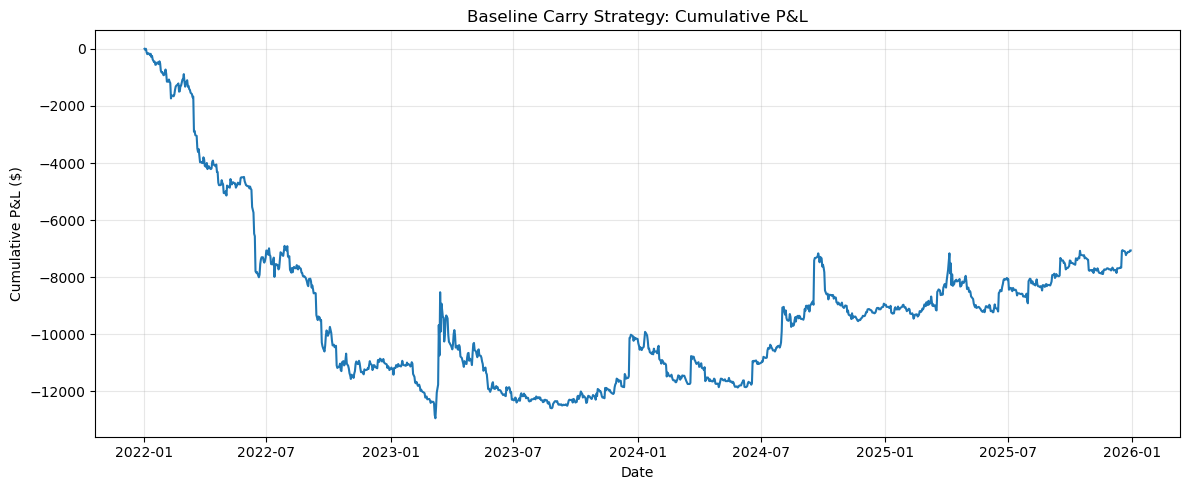

In [18]:

idx = sofr_implied.index

# 2nd contract implied rate each day
r2 = []
for d in idx:
    _, second = front_and_second_contract(d)
    r2.append(sofr_implied.loc[d, second] if second is not None else np.nan)
r2 = pd.Series(r2, index=idx, name="second_rate")

dr = r2.diff()
pnl = (-dr * 100 * 25).fillna(0.0)  # dollars per contract
equity = pnl.cumsum()

def sharpe(pnl_series, periods=252):
    mu = pnl_series.mean()
    sd = pnl_series.std(ddof=0)
    return np.nan if sd==0 else (mu/sd)*np.sqrt(periods)

def max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    dd = equity_curve - running_max
    return dd.min()

base_stats = pd.Series({
    "Cumulative P&L ($)": equity.iloc[-1],
    "Sharpe (daily, 252)": sharpe(pnl),
    "Max drawdown ($)": max_drawdown(equity)
}, name="Baseline carry")
display(base_stats)

plt.figure(figsize=FIGSIZE)
plt.plot(equity.index, equity.values)
plt.title("Baseline Carry Strategy: Cumulative P&L")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L ($)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [19]:

# Regime splits
pnl_dt = pnl.copy()
pnl_dt.index = pd.to_datetime(pnl_dt.index)

hike_mask = (pnl_dt.index >= pd.Timestamp("2022-03-01")) & (pnl_dt.index <= pd.Timestamp("2023-07-31"))
plat_mask = (pnl_dt.index >= pd.Timestamp("2023-08-01")) & (pnl_dt.index <= pd.Timestamp("2024-12-31"))

stats_reg = pd.DataFrame({
    "Hiking phase": {
        "Cumulative P&L ($)": pnl_dt[hike_mask].sum(),
        "Sharpe": sharpe(pnl_dt[hike_mask]),
        "Max drawdown ($)": max_drawdown(pnl_dt[hike_mask].cumsum()),
    },
    "Plateau/Cutting phase": {
        "Cumulative P&L ($)": pnl_dt[plat_mask].sum(),
        "Sharpe": sharpe(pnl_dt[plat_mask]),
        "Max drawdown ($)": max_drawdown(pnl_dt[plat_mask].cumsum()),
    }
}).T
display(stats_reg)


,Cumulative P&L ($),Sharpe,Max drawdown ($)
Hiking phase,-11200.0,-1.583216,-12050.0
Plateau/Cutting phase,3312.5,0.750845,-2375.0


### Enhanced strategy: front-end inversion filter

Hold the long 2nd-contract position **only when** the very front end is inverted: $r_{2nd} \le r_{front}$.

Cumulative P&L ($)     2150.00000
Sharpe (daily, 252)       0.17673
Max drawdown ($)      -4175.00000
Name: Enhanced (inversion filter), dtype: float64

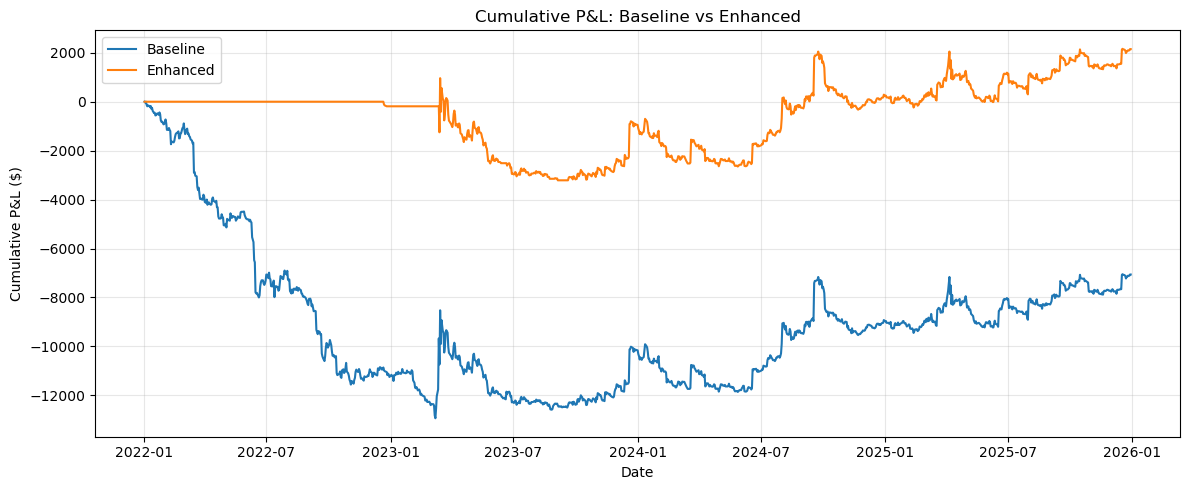

In [20]:

# Front rate series
front_rate = []
for d in sofr_implied.index:
    front, second = front_and_second_contract(d)
    if (front is None) or (second is None):
        front_rate.append(np.nan)
    else:
        front_rate.append(sofr_implied.loc[d, front])
front_rate = pd.Series(front_rate, index=sofr_implied.index, name="front_rate")

signal = (r2 <= front_rate).astype(float)  # 1 = long, 0 = flat

pnl_enh = (-r2.diff() * 100 * 25).fillna(0.0) * signal.shift(1).fillna(0.0)
equity_enh = pnl_enh.cumsum()

enh_stats = pd.Series({
    "Cumulative P&L ($)": equity_enh.iloc[-1],
    "Sharpe (daily, 252)": sharpe(pnl_enh),
    "Max drawdown ($)": max_drawdown(equity_enh)
}, name="Enhanced (inversion filter)")
display(enh_stats)

plt.figure(figsize=FIGSIZE)
plt.plot(equity.index, equity.values, label="Baseline")
plt.plot(equity_enh.index, equity_enh.values, label="Enhanced")
plt.title("Cumulative P&L: Baseline vs Enhanced")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Limitations

- No transaction costs / bid-ask spreads (especially important around rolls)
- Constant DV01 assumption
- No margining/financing or slippage
- Uses daily closes only
